In [1]:
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [2]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('acc') >= 0.96):   
            print("Reached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [3]:
EPOCHS = 50
INIT_LR = 3e-3
BS =32
default_image_size = tuple((224, 224))
image_size = 0
width=224
height=224
depth=3
train_dir=r"D:\DP\Rice Leaf Disease Images"
#valid_dir=r"C:\Users\Glau\Desktop\DP\Pediastrum_cnn\Test"
train_folder=listdir(train_dir)
#valid_folder=listdir(valid_dir)

In [4]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [5]:
train_image_list, train_image_label= [], []
for disease_folder in train_folder:
    print(f"processing {disease_folder} ...")
    disease_img_folder= listdir(f"{train_dir}/{disease_folder}")
    #print(disease_img_folder)
    for disease_img in disease_img_folder:
    #for disease_img in disease_img_folder[: : 2]:    
        image_directory = f"{train_dir}/{disease_folder}/{disease_img}"
        if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True or  image_directory.endswith(".png") == True:
            train_image_list.append(convert_image_to_array(image_directory))
            train_image_label.append(disease_folder)
print("[INFO] Image loading completed")

processing Bacterialblight ...
processing Blast ...
processing Brownspot ...
processing Tungro ...
[INFO] Image loading completed


In [6]:
print(len(train_image_label))

5932


In [7]:
label_binarizer = LabelBinarizer()
bin_train_image_labels = label_binarizer.fit_transform(train_image_label)
#bin_valid_image_labels = label_binarizer.fit_transform(valid_image_label)
pickle.dump(label_binarizer,open('Label_Instance_cancer_cell_new2.pk', 'wb'))
n_classes = len(label_binarizer.classes_)

In [8]:
np_train_image_list = np.array(train_image_list, dtype=np.float32) / 255.0

In [9]:
print(len(np_train_image_list))

5932


In [10]:
from tensorflow.keras import models

from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras import layers
#
# image dimensions
#

img_height = 224
img_width = 224
img_channels = 3

#
# network params
#

cardinality = 32


def residual_network(x):
    """
    ResNeXt by default. For ResNet set `cardinality` = 1 above.
    
    """
    def add_common_layers(y):
        y = layers.BatchNormalization()(y)
        y = layers.LeakyReLU()(y)

        return y

    def grouped_convolution(y, nb_channels, _strides):
        # when `cardinality` == 1 this is just a standard convolution
        if cardinality == 1:
            return layers.Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
        
        assert not nb_channels % cardinality
        _d = nb_channels // cardinality

        # in a grouped convolution layer, input and output channels are divided into `cardinality` groups,
        # and convolutions are separately performed within each group
        groups = []
        for j in range(cardinality):
            group = layers.Lambda(lambda z: z[:, :, :, j * _d:j * _d + _d])(y)
            groups.append(layers.Conv2D(_d, kernel_size=(3, 3), strides=_strides, padding='same')(group))
            
        # the grouped convolutional layer concatenates them as the outputs of the layer
        y = layers.concatenate(groups)

        return y

    def residual_block(y, nb_channels_in, nb_channels_out, _strides=(1, 1), _project_shortcut=False):
        """
        Our network consists of a stack of residual blocks. These blocks have the same topology,
        and are subject to two simple rules:

        - If producing spatial maps of the same size, the blocks share the same hyper-parameters (width and filter sizes).
        - Each time the spatial map is down-sampled by a factor of 2, the width of the blocks is multiplied by a factor of 2.
        """
        shortcut = y

        # we modify the residual building block as a bottleneck design to make the network more economical
        y = layers.Conv2D(nb_channels_in, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        y = add_common_layers(y)

        # ResNeXt (identical to ResNet when `cardinality` == 1)
        y = grouped_convolution(y, nb_channels_in, _strides=_strides)
        y = add_common_layers(y)

        y = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=(1, 1), padding='same')(y)
        # batch normalization is employed after aggregating the transformations and before adding to the shortcut
        y = layers.BatchNormalization()(y)

        # identity shortcuts used directly when the input and output are of the same dimensions
        if _project_shortcut or _strides != (1, 1):
            # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
            # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
            shortcut = layers.Conv2D(nb_channels_out, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        y = layers.add([shortcut, y])

        # relu is performed right after each batch normalization,
        # expect for the output of the block where relu is performed after the adding to the shortcut
        y = layers.ReLU()(y)

        return y

    # conv1
    x = layers.Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
    x = add_common_layers(x)

    # conv2
    x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
    for i in range(3):
        project_shortcut = True if i == 0 else False
        x = residual_block(x, 64, 128, _project_shortcut=project_shortcut)

    # conv3
    for i in range(4):
        # down-sampling is performed by conv3_1, conv4_1, and conv5_1 with a stride of 2
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 128, 256, _strides=strides)

    # conv4
    for i in range(6):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 256, 1024, _strides=strides)

    # conv5
    for i in range(3):
        strides = (2, 2) if i == 0 else (1, 1)
        x = residual_block(x, 1024, 2048, _strides=strides)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(4,activation='softmax')(x)

    return x


image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = residual_network(image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 2432        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

conv2d_300 (Conv2D)             (None, 14, 14, 8)    584         lambda_279[0][0]                 
__________________________________________________________________________________________________
conv2d_301 (Conv2D)             (None, 14, 14, 8)    584         lambda_280[0][0]                 
__________________________________________________________________________________________________
conv2d_302 (Conv2D)             (None, 14, 14, 8)    584         lambda_281[0][0]                 
__________________________________________________________________________________________________
conv2d_303 (Conv2D)             (None, 14, 14, 8)    584         lambda_282[0][0]                 
__________________________________________________________________________________________________
conv2d_304 (Conv2D)             (None, 14, 14, 8)    584         lambda_283[0][0]                 
__________________________________________________________________________________________________
conv2d_305

In [11]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

print("[INFO] training network...")

[INFO] training network...


In [13]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,classification_report 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [14]:
conf_matrix_list_of_arrays = []
#loss_per_fold = []
seed = 13   # for reproducibility you can change it. 
np.random.seed(seed)
kfold = KFold(5, True, seed)
for train_idx, val_idx in kfold.split(np_train_image_list, y=bin_train_image_labels):
    #print('train: %s, val: %s' % (train_idx, val_idx))
    x_train, x_val = np_train_image_list[train_idx], np_train_image_list[val_idx]
    y_train, y_val = bin_train_image_labels[train_idx], bin_train_image_labels[val_idx]
    history=model.fit(x_train, y_train,
                  validation_data=(x_val, y_val),
                  batch_size=BS,
                  epochs=EPOCHS, verbose=1        
                  )
    ycalculated = model.predict(x_val)
    yhat_classes =np.argmax(ycalculated,axis=1)
    rounded_labels=np.argmax(y_val,axis=1)                           
    conf_matrix = confusion_matrix(rounded_labels,yhat_classes)
    conf_matrix_list_of_arrays .append(conf_matrix)

Train on 4745 samples, validate on 1187 samples
Epoch 1/50
4745/4745 [==============================] - 114s 24ms/sample - loss: 1.7190 - accuracy: 0.6110 - val_loss: 24.6787 - val_accuracy: 0.2502
Epoch 2/50
4745/4745 [==============================] - 62s 13ms/sample - loss: 0.7148 - accuracy: 0.7568 - val_loss: 3.7949 - val_accuracy: 0.4549
Epoch 3/50
4745/4745 [==============================] - 163s 34ms/sample - loss: 0.5034 - accuracy: 0.8263 - val_loss: 0.6059 - val_accuracy: 0.7751
Epoch 4/50
4745/4745 [==============================] - 285s 60ms/sample - loss: 0.4346 - accuracy: 0.8413 - val_loss: 1.0264 - val_accuracy: 0.6537
Epoch 5/50
4745/4745 [==============================] - 137s 29ms/sample - loss: 0.3494 - accuracy: 0.8744 - val_loss: 2.0665 - val_accuracy: 0.6158
Epoch 6/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.2635 - accuracy: 0.9083 - val_loss: 0.6174 - val_accuracy: 0.8029
Epoch 7/50
4745/4745 [==============================] - 64s

4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.3702 - val_accuracy: 0.9132
Epoch 6/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0394 - accuracy: 0.9897 - val_loss: 0.0433 - val_accuracy: 0.9773
Epoch 7/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0725 - accuracy: 0.9802 - val_loss: 0.0176 - val_accuracy: 0.9933
Epoch 8/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0151 - accuracy: 0.9943 - val_loss: 0.0029 - val_accuracy: 0.9983
Epoch 9/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0148 - accuracy: 0.9945 - val_loss: 2.9152e-04 - val_accuracy: 1.0000
Epoch 10/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.0024 - val_accuracy: 0.9992
Epoch 11/50
4745/4745 [==============================] - 63s 13ms/sample - loss: 0.0164 - accuracy: 0.9962 - val_loss:

4746/4746 [==============================] - 63s 13ms/sample - loss: 0.0069 - accuracy: 0.9975 - val_loss: 4.6282e-04 - val_accuracy: 1.0000
Epoch 10/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0078 - accuracy: 0.9975 - val_loss: 1.3008e-04 - val_accuracy: 1.0000
Epoch 11/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0081 - accuracy: 0.9979 - val_loss: 0.0186 - val_accuracy: 0.9924
Epoch 12/50
4746/4746 [==============================] - 63s 13ms/sample - loss: 0.0055 - accuracy: 0.9985 - val_loss: 1.1094e-04 - val_accuracy: 1.0000
Epoch 13/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0029 - accuracy: 0.9989 - val_loss: 1.5088e-04 - val_accuracy: 1.0000
Epoch 14/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0168 - accuracy: 0.9941 - val_loss: 0.0344 - val_accuracy: 0.9865
Epoch 15/50
4746/4746 [==============================] - 63s 13ms/sample - loss: 0.0093 - accuracy: 0.

4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0040 - accuracy: 0.9989 - val_loss: 1.1922e-04 - val_accuracy: 1.0000
Epoch 13/50
4746/4746 [==============================] - 63s 13ms/sample - loss: 0.0018 - accuracy: 0.9996 - val_loss: 9.6216e-05 - val_accuracy: 1.0000
Epoch 14/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0074 - val_accuracy: 0.9966
Epoch 15/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 2.4801e-04 - accuracy: 1.0000 - val_loss: 5.3090e-05 - val_accuracy: 1.0000
Epoch 16/50
4746/4746 [==============================] - 63s 13ms/sample - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0039 - val_accuracy: 0.9992
Epoch 17/50
4746/4746 [==============================] - 63s 13ms/sample - loss: 0.0070 - accuracy: 0.9981 - val_loss: 0.0176 - val_accuracy: 0.9958
Epoch 18/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0021 - accuracy: 0.

4746/4746 [==============================] - 63s 13ms/sample - loss: 9.3547e-05 - accuracy: 1.0000 - val_loss: 7.0141e-06 - val_accuracy: 1.0000
Epoch 16/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 2.2842e-04 - accuracy: 0.9998 - val_loss: 1.8963e-06 - val_accuracy: 1.0000
Epoch 17/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 1.6814e-04 - accuracy: 1.0000 - val_loss: 3.7852e-06 - val_accuracy: 1.0000
Epoch 18/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 5.9787e-04 - accuracy: 0.9996 - val_loss: 3.1682e-06 - val_accuracy: 1.0000
Epoch 19/50
4746/4746 [==============================] - 64s 13ms/sample - loss: 0.0139 - accuracy: 0.9968 - val_loss: 0.0079 - val_accuracy: 0.9966
Epoch 20/50
4746/4746 [==============================] - 64s 14ms/sample - loss: 7.7736e-04 - accuracy: 0.9996 - val_loss: 0.0179 - val_accuracy: 0.9941
Epoch 21/50
4746/4746 [==============================] - 63s 13ms/sample - loss: 0

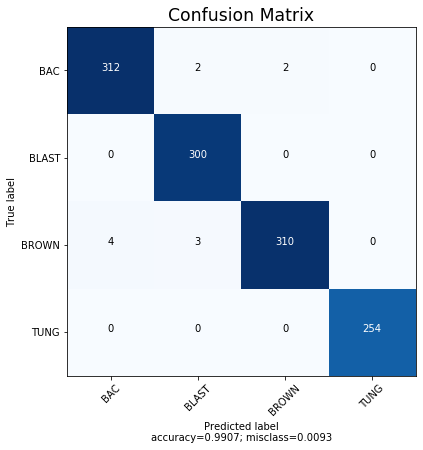

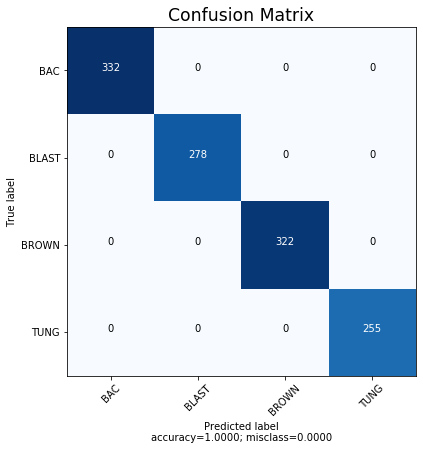

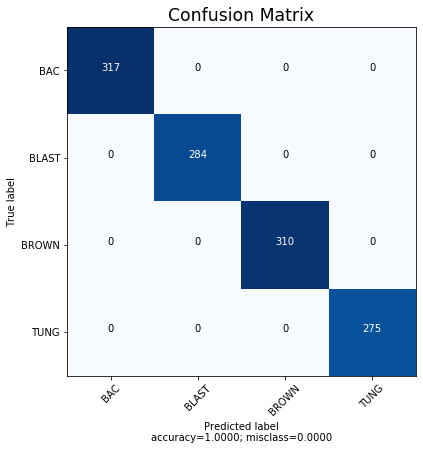

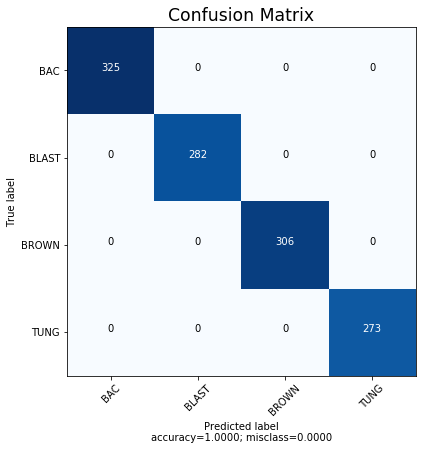

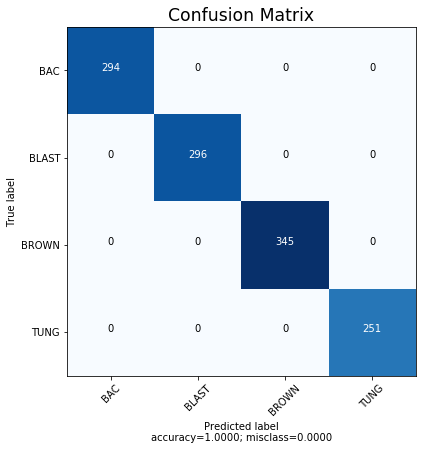

In [15]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 'xx-large')

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
for i in range(0,5):
    plot_confusion_matrix(conf_matrix_list_of_arrays[i], 
                      normalize = False,
                      target_names = ['BAC', 'BLAST', 'BROWN','TUNG'],
                      title  = "Confusion Matrix")

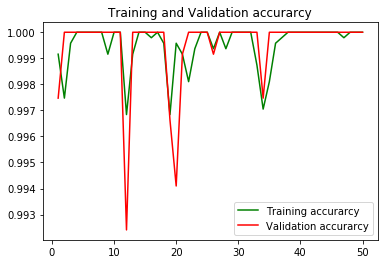

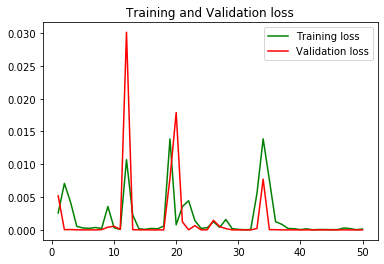

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'g', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score,classification_report 
target_names = ['BAC', 'BLAST', 'BROWN','TUNG']
print(classification_report(rounded_labels, yhat_classes, target_names=target_names))

              precision    recall  f1-score   support

         BAC       1.00      1.00      1.00       294
       BLAST       1.00      1.00      1.00       296
       BROWN       1.00      1.00      1.00       345
        TUNG       1.00      1.00      1.00       251

    accuracy                           1.00      1186
   macro avg       1.00      1.00      1.00      1186
weighted avg       1.00      1.00      1.00      1186



In [18]:
class_to_label_map={0:'BAC', 1:'BLAST', 2:'BROWN',3:'TUNG' }

C:\Users\Glau\.conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


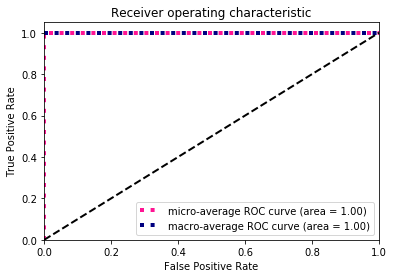

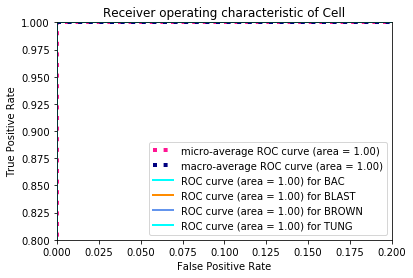

In [19]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle

n_classes =4

from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2
lb = LabelBinarizer()
lb.fit(rounded_labels)
y_test= lb.transform(rounded_labels)
snn_pred = lb.transform(yhat_classes)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], snn_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), snn_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes-97), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], class_to_label_map[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw,color='white')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of Cell')
plt.legend(loc="lower right")
plt.show()